# Project: Implied Volatility vs Realized Volatility for an Africa-Exposure ETF  
### with a West Africa Regime Overlay

---

The goal is testing whether implied volatility (IV) from options on an Africa-exposure ETF forecasts next-week realized volatility (RV), and how forecast errors vary across West Africa regimes defined by Naira (NGN) volatility.

Given my Nigerian background, AFK will be the first option since it has Pan-African exposure and EZA is South Africa focused. AFK and EZA are the only two ETFs that can be traded with in the America. 

In [1]:
#Before running this notebook, install the required packages by executing the following commands in a code cell:

# ---- Core finance & data libraries ----
!pip install yfinance            # download market data
!pip install pandas              # data handling
!pip install numpy               # math & array operations
!pip install matplotlib          # plotting (if you graph volatility)
!pip install scipy               # numerical methods, e.g., Brent root-finding

# ---- Option pricing & implied volatility ----
!pip install py_vollib           # Black–Scholes–Merton pricing + implied vol
# (if py_vollib gives compilation errors, use this instead)
!pip install py_vollib-vectorized

# ---- Optional but recommended ----
!pip install seaborn             # prettier charts (optional)
!pip install plotly              # interactive graphs (optional)
!pip install tqdm                # progress bars for loops
!pip install requests            # for robust HTTP sessions

# ---- For fallback caching or file handling ----
!pip install json5               # reading/writing JSON cache
!pip install pathlib             # (usually built-in with Python ≥3.4)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 17.3 MB/s  0:00:00m0:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires pyarrow>=7.0, which is not installed.
dask-expr 1.1.13 requires pyarrow>=14.0.1, which is not installed.
defeatbeta-api 0.0.23 requires numpy>=2.2.5, but you have numpy 1.26.4 which is incompatible.
streamlit 1.37.1 requires rich<14,>=10.14.0, but you have rich 14.2.0 which is incompatible.


**Implied Volatility (IV):**

Simplied volatility is the value of $\sigma $ that satisfies the **Black–Scholes option pricing formula** for a given market option price $ C_{\text{mkt}} $:

$$
C_{\text{mkt}} = S_0 e^{-qT} N(d_1) - K e^{-rT} N(d_2)
$$

where

$$
d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + (r - q + \tfrac{1}{2}\sigma^2)T}{\sigma \sqrt{T}},
\quad
d_2 = d_1 - \sigma \sqrt{T}
$$

and

- $C_{\text{mkt}} $ = option's market price 
- S_0 = current underlying price <!-- current market price -->
- K = strike price  <!-- fixed price (or exercised price) in option contract| for call - buy @ K & for put - sell @ K -->
- r = risk-free rate  <!-- continuously compounded annualized return of a risk-free asset -->
- q = dividend yield  <!-- ratio of a company's annual dividend payment to its stock price, which can influence the value of call & put options -->
- T = time to expiration (in years)  <!-- time remaining until the option’s expiration date, can be called "theta decay" -->
- N =  cumulative normal distribution <!-- probability that a standard normally distributed random variable is less than or equal to a given number of standard deviations from the mean -->

<!-- Note: The strike price is the fixed amount you will pay (or receive) in the future, while the present value is how much that future payment (and the option’s overall payoff) is worth today, after adjusting for time and interest.  -->

The **implied volatility** $\sigma_{\text{imp}}$ is found by *inverting* this equation — i.e., solving for $\sigma$ such that the model price equals the observed market price. Since $N(d_{1})$ and $N(d_{2})$ are nonlinear cumulative normal functions, there’s no analytical way to isolate σ symbolically. \

This means we cannot just “move terms around” like in normal algebra.

So instead, we invert the equation numerically — i.e., find the σ that makes the theoretical Black–Scholes price equal the observed market price. This is where Numerical inversion can be used.

$$f(σ)=C_{BS}​(S_0​,K,r,q,T,σ)−C_{mkt}$$

From here, find the root: 

$$f(σ_{imp}​)=0$$

Since we cannot do this analytically, a root-finding algorithm can be utilized. Our data provides IV already, but if we were to compute it ourselves, the *py_vollib* library would have been used. Example code would look like: 

In [2]:
from py_vollib.black_scholes_merton.implied_volatility import implied_volatility

option_price = 2.50   # market option price
S = 100.0             # spot
K = 105.0             # strike
t = 30/365            # time to expiry (years)
r = 0.05              # risk-free rate
q = 0.0               # dividend yield
flag = 'c'            # 'c' for call, 'p' for put

iv = implied_volatility(
    option_price,  # price
    S,             # spot
    K,             # strike
    t,             # <-- time first
    r,             # <-- then risk-free
    q,             # <-- then dividend
    flag           # <-- then 'c' or 'p'
)

print("Implied volatility:", iv)


Implied volatility: 0.37751241493004


**Realized Volatility (RV)** 

The **realized volatility** over a 5-day window measures how much the asset price actually fluctuated in that period.  
It is computed from daily log-returns and annualized to make it comparable with implied volatility.

#### Formula

$$
\text{RV}_{t \to t+5} = 
\sqrt{
\sum_{d=1}^{5} r_{t+d}^2 \cdot \frac{252}{5}
},
\quad 
r_{t+d} = \ln\!\left(\frac{S_{t+d}}{S_{t+d-1}}\right)
$$

Where:
- S_t = price of the underlying asset on day \(t\)
- r_{t+d} = daily log return
- 252 = approximate number of trading days per year
- 5 = number of days in the window (e.g., a trading week)
- $RV_{t \to t+5}$ = annualized realized volatility over the 5-day window

What is the relationship between IV and RV? 

#### Interpretation

- **Realized Volatility (RV):** reflects *actual* price fluctuations observed in historical data.  
- **Implied Volatility (IV):** reflects *expected* future volatility inferred from option prices.  

Comparing these two helps assess whether options are **over- or under-priced** relative to recent market behavior.


Import Data \
Clean it \
Map IV over 2 years \
Map RV over 2 years \
IV is \likely provided \
RV is unlikely provided so compute it \
Create another column with it next to IV  
... thennn map RV \
Compare them... specifically how IV today relates to RV in a week \
Simply map them \
then make the comparison a secondary calculation \

In [3]:
import pandas as pd
import numpy as np 

df = pd.read_csv('afk_options-overview-history-11-01-2025.csv') 

In [4]:
from pathlib import Path

root = Path.cwd()  # /Users/chidu/Downloads/Erdos_Africa
csv_path = root / "afk_options-overview-history-11-01-2025.csv"
print(csv_path.exists(), csv_path)  # should print: True /Users/chidu/...

df_afk = pd.read_csv(csv_path, sep=None, engine="python", parse_dates=["Date"])
print(df_afk.shape)
df_afk


True /Users/chidu/Downloads/Erdos_Africa/afk_options-overview-history-11-01-2025.csv
(581, 10)


,Date,Imp Vol,1D IV Chg,IV Rank,IV Pctl,P/C Vol,Options Vol,P/C OI,Total OI,Last
0,2025-10-31,45.55%,-19.10%,39.51%,64%,1.2,11.0,0.150000,92.0,23.940
1,2025-10-30,64.65%,+7.23%,65.16%,90%,2.0,3.0,0.126582,89.0,24.080
2,2025-10-29,57.42%,-1.84%,55.45%,78%,0.0,5.0,0.135135,84.0,24.060
3,2025-10-22,59.26%,-5.54%,57.92%,81%,0.0,1.0,0.136986,83.0,23.780
4,2025-10-21,64.80%,+15.57%,65.37%,90%,0.0,4.0,0.144928,79.0,24.038
...,...,...,...,...,...,...,...,...,...,...
576,2021-08-03,0.00%,unch,0.00%,0%,0.0,0.0,0.000000,0.0,21.790
577,2021-08-02,0.00%,unch,0.00%,0%,0.0,0.0,0.000000,0.0,21.760
578,2021-07-30,0.00%,unch,0.00%,0%,0.0,0.0,0.000000,0.0,21.730
579,2021-07-29,0.00%,unch,0.00%,0%,0.0,0.0,0.000000,0.0,21.820


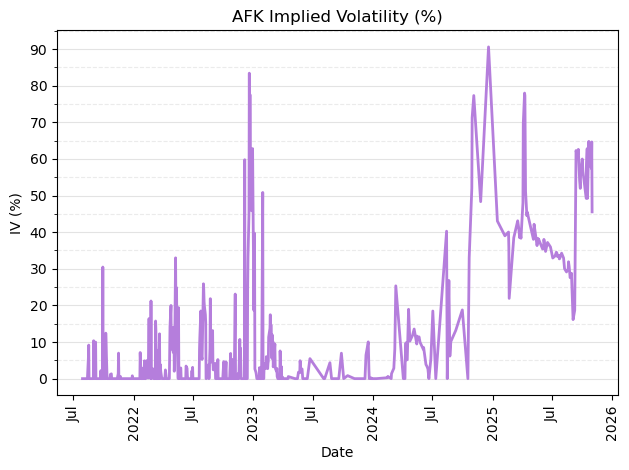

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, AutoMinorLocator

fig, ax = plt.subplots()

# darker lavender line
ax.plot(iv_afk.index, iv_afk["IV_pct"], color="#B57EDC", linewidth=2)

ax.set_title("AFK Implied Volatility (%)")
ax.set_ylabel("IV (%)")
ax.set_xlabel("Date")

# >>> more horizontal lines
ax.yaxis.set_major_locator(MaxNLocator(nbins=12))     # more major ticks
ax.yaxis.set_minor_locator(AutoMinorLocator(2))       # add minor ticks between majors
ax.grid(which="major", axis="y", linestyle="-", alpha=0.35)
ax.grid(which="minor", axis="y", linestyle="--", alpha=0.25)

# vertical date labels
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for lab in ax.get_xticklabels():
    lab.set_rotation(90)
    lab.set_ha("center")

plt.tight_layout()
plt.show()


/opt/homebrew/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


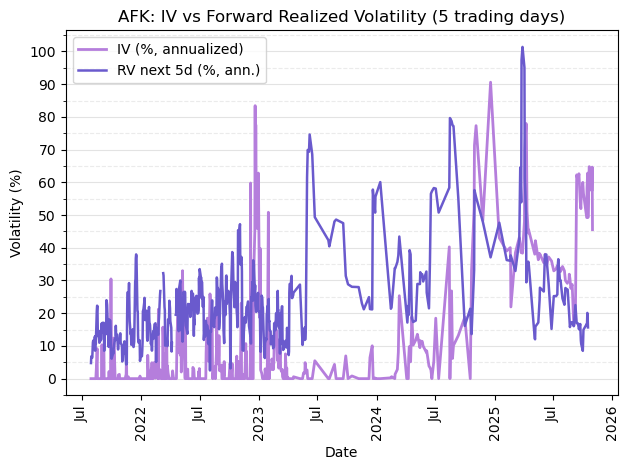

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, AutoMinorLocator

# --- 1) Ensure df_afk is time-indexed and 'Last' is numeric ---
dfa = df_afk.copy()
dfa['Date'] = pd.to_datetime(dfa['Date'], errors='coerce')
dfa = dfa.sort_values('Date').dropna(subset=['Date'])
dfa['Last'] = pd.to_numeric(dfa['Last'], errors='coerce')
dfa = dfa.set_index('Date')

# --- 2) Helper: forward realized vol over next `horizon_days` starting next day ---
def forward_realized_vol_pct(
    px: pd.Series,
    horizon_days: int = 5,
    annualization: int = 252,
    use_log_returns: bool = True,
) -> pd.Series:
    """
    RV_{t->t+h} aligned at t.
    - Computes std of returns over next `horizon_days` trading days, annualized.
    - Aligns that value back to date t.
    """
    r = np.log(px).diff() if use_log_returns else px.pct_change()
    rv = r.rolling(horizon_days).std(ddof=1) * np.sqrt(annualization)   # backward-looking at time u
    rv_aligned = rv.shift(-horizon_days) * 100.0  # shift back so u = t+h → value sits at t
    return rv_aligned

# 3) Compute 5-day forward RV (percent)
rv5_pct = forward_realized_vol_pct(dfa['Last'], horizon_days=5)

# 4) Join with your IV (assumes you already built iv_afk with IV_pct indexed by Date)
iv_rv = iv_afk[['IV_pct']].join(rv5_pct.rename('RV5_pct'), how='inner')

# --- 5) Plot: darker lavender IV + RV with more horizontal lines & vertical dates ---
fig, ax = plt.subplots()

ax.plot(iv_rv.index, iv_rv['IV_pct'], label='IV (%, annualized)', color="#B57EDC", linewidth=2)
ax.plot(iv_rv.index, iv_rv['RV5_pct'], label='RV next 5d (%, ann.)', color="#6A5ACD", linewidth=1.8)

ax.set_title("AFK: IV vs Forward Realized Volatility (5 trading days)")
ax.set_ylabel("Volatility (%)")
ax.set_xlabel("Date")

# More horizontal guides
ax.yaxis.set_major_locator(MaxNLocator(nbins=12))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(which="major", axis="y", linestyle="-", alpha=0.35)
ax.grid(which="minor", axis="y", linestyle="--", alpha=0.25)

# Vertical date ticks
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for lab in ax.get_xticklabels():
    lab.set_rotation(90)
    lab.set_ha("center")

ax.legend()
plt.tight_layout()
plt.show()


Historically, what has impacted the AFK? Which sectors comprise it? 

What are Options and how does it relate to IV?

How does the Naira relate to AFK? 

State factors that impact the Naira